In [16]:
%pip install pandas opencv-python-headless mediapipe scikit-learn matplotlib imbalanced-learn tqdm imutils pyarrow

  Using cached pyarrow-16.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-16.1.0-cp312-cp312-manylinux_2_28_x86_64.whl (40.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import numpy as np
from imutils import paths
import mediapipe as mp
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
import shutil
import pandas as pd
from sklearn.preprocessing import LabelEncoder

## Testando caminho

In [ ]:
## Testando caminho

(np.float64(-0.5), np.float64(47.5), np.float64(47.5), np.float64(-0.5))

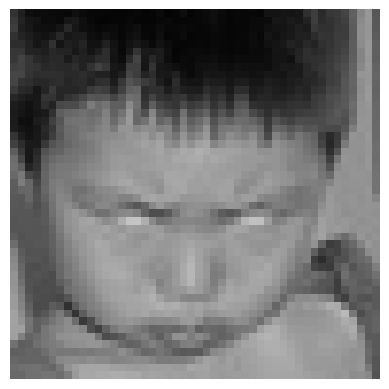

In [4]:
img = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_10118481.jpg')
plt.imshow(img,'binary')
plt.axis(False)

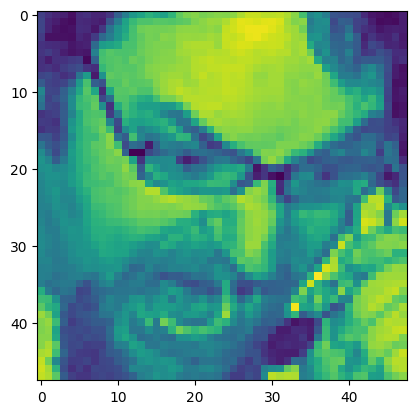

In [5]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/test/angry/PrivateTest_10131363.jpg', 0)
plt.imshow(image)

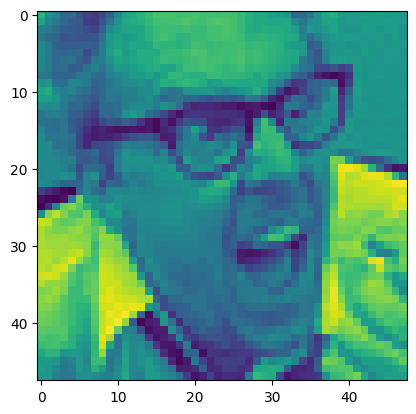

In [6]:
image = cv2.imread('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive/train/angry/Training_3908.jpg', 0)
plt.imshow(image)

## Iniciando

In [26]:
# Defina o diretório base
data_dir = '/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/archive'

# Emotions para considerar
emotions = ['angry', 'sad', 'surprise', 'happy']
emotion_to_num = {'angry': 0, 'sad': 1, 'surprise': 2, 'happy': 3}

# Função para carregar as imagens e seus rótulos
def load_images_and_labels(base_dir, emotions):
    data = []
    labels = []
    for emotion in emotions:
        emotion_dir = os.path.join(base_dir, emotion)
        if os.path.isdir(emotion_dir):
            for img_name in os.listdir(emotion_dir):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(emotion_dir, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        data.append(img)
                        labels.append(emotion)
    return np.array(data), np.array(labels)

# Carregar imagens e rótulos
train_images, train_labels = load_images_and_labels(os.path.join(data_dir, 'train'), emotions)
test_images, test_labels = load_images_and_labels(os.path.join(data_dir, 'test'), emotions)

# Combinar train e test
all_images = np.concatenate((train_images, test_images), axis=0)
all_labels = np.concatenate((train_labels, test_labels), axis=0)

# Contagem das imagens por emoção
emotion_counts_before = {emotion: np.sum(all_labels == emotion) for emotion in emotions}
print("Contagem de imagens antes de remover as imagens sem face:")
for emotion, count in emotion_counts_before.items():
    print(f"{emotion}: {count}")

Contagem de imagens antes de remover as imagens sem face:
angry: 4953
sad: 6077
surprise: 4002
happy: 8989


In [27]:
# Remover imagens sem face (utilizando um detector facial do MediaPipe)
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

def remove_images_without_faces(images, labels):
    valid_images = []
    valid_labels = []
    for img, label in zip(images, labels):
        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
        if results.detections:
            valid_images.append(img)
            valid_labels.append(label)
    return np.array(valid_images), np.array(valid_labels)

# Remover imagens sem face
all_images, all_labels = remove_images_without_faces(all_images, all_labels)

# Contagem das imagens por emoção após remover imagens
emotion_counts = {emotion: np.sum(all_labels == emotion) for emotion in emotions}
print("Contagem de imagens após remoção de imagens sem face:")
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

I0000 00:00:1720035201.748452    4591 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720035201.773686   33202 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1720035201.775616   33197 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Contagem de imagens após remoção de imagens sem face:
angry: 4529
sad: 5581
surprise: 3833
happy: 8733


In [28]:
# Número de imagens na classe minoritária
min_count = emotion_counts['surprise']

# Função para realizar undersampling
def undersample(images, labels, target_count):
    undersampled_images = []
    undersampled_labels = []
    for emotion in emotions:
        emotion_images = images[labels == emotion]
        emotion_labels = labels[labels == emotion]
        if len(emotion_images) > target_count:
            emotion_images, emotion_labels = resample(emotion_images, emotion_labels, replace=False, n_samples=target_count, random_state=42)
        undersampled_images.append(emotion_images)
        undersampled_labels.append(emotion_labels)
    return np.concatenate(undersampled_images), np.concatenate(undersampled_labels)

# Realizar undersampling
balanced_images, balanced_labels = undersample(all_images, all_labels, min_count)

# Verificar contagem após undersampling
unique, counts = np.unique(balanced_labels, return_counts=True)
print("Contagem de imagens após undersampling:")
for emotion, count in zip(unique, counts):
    print(f"{emotion}: {count}")

Contagem de imagens após undersampling:
angry: 3833
happy: 3833
sad: 3833
surprise: 3833


In [29]:
# Extrair landmarks usando MediaPipe
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

def extract_landmarks(images):
    landmarks_list = []
    for img in images:
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                landmarks = []
                for lm in face_landmarks.landmark:
                    landmarks.append(lm.x)
                    landmarks.append(lm.y)
                    landmarks.append(lm.z)
                landmarks_list.append(landmarks)
        else:
            landmarks_list.append([0] * 468 * 3)  # Caso não encontre landmarks, preencha com zeros
    return np.array(landmarks_list)

# Extrair landmarks das imagens balanceadas
landmarks = extract_landmarks(balanced_images)

# Converter para DataFrame e salvar em .parquet
balanced_labels_numeric = [emotion_to_num[label] for label in balanced_labels]
df = pd.DataFrame(landmarks)
df['label'] = balanced_labels_numeric
df.to_parquet('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/landmarks_balanced.parquet', engine='pyarrow')

print("Landmarks extraídos e salvos em formato .parquet")

I0000 00:00:1720035392.647048    4591 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1720035392.702778   34627 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.01), renderer: NVIDIA GeForce GTX 750 Ti/PCIe/SSE2
W0000 00:00:1720035392.706364   34623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1720035392.713594   34619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/.venv/lib/python3.12/site-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


Landmarks extraídos e salvos em formato .parquet


## Verificando DF

In [4]:
# Carregar os landmarks salvos em .parquet
landmarks_df = pd.read_parquet('/home/viniciuss/Documents/projetos/FER-2013_emotion_detection/landmarks_balanced.parquet')

# Exibir informações básicas sobre os dados
print('Primeiras linhas do DataFrame:')
print(landmarks_df.head())

print('\nTamanho do DataFrame:')
print(landmarks_df.shape)

print('\nVerificar se há valores ausentes:')
print(landmarks_df.isnull().sum())

# Exemplo de landmarks para análise (supondo que a segunda coluna contém os landmarks)
example_landmarks = landmarks_df.iloc[0, :-1]  # Excluir a última coluna que contém os rótulos

print('\nVerificar o intervalo dos valores de landmarks faciais:')
print(f"Valores mínimos: {example_landmarks.min()}")
print(f"Valores máximos: {example_landmarks.max()}")

Primeiras linhas do DataFrame:
          0         1         2         3         4         5         6  \
0  0.542199  0.738833 -0.070273  0.535373  0.635229 -0.179770  0.532786   
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.429018  0.756555 -0.045187  0.431486  0.689657 -0.183432  0.437436   
3  0.455101  0.528905 -0.093874  0.454369  0.438817 -0.144501  0.452669   
4  0.294850  0.448779 -0.197011  0.312964  0.295665 -0.208506  0.317771   

          7         8         9  ...      1395      1396      1397      1398  \
0  0.657359 -0.085466  0.492651  ...  0.566294  0.417931 -0.050389  0.741274   
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.700313 -0.078584  0.430007  ...  0.549186  0.452173 -0.090314  0.760878   
3  0.470683 -0.087341  0.422387  ...  0.478693  0.311043  0.005461  0.612753   
4  0.370636 -0.152194  0.326018  ...  0.462963  0.223220  0.047739  0.674564   

       1399      1400      1401      

In [8]:
emocoes_unicas = landmarks_df['label'].unique()
print(emocoes_unicas)

estatisticas_emocoes = landmarks_df['label'].describe()
print(estatisticas_emocoes)

[0 1 2 3]
count    15332.00000
mean         1.50000
std          1.11807
min          0.00000
25%          0.75000
50%          1.50000
75%          2.25000
max          3.00000
Name: label, dtype: float64
